# 다음 분기에 어떤 게임을 설계해야 할까
---
## Data Description
- Name : 게임의 이름입니다.
- Platform : 게임이 지원되는 플랫폼의 이름입니다.
- Year : 게임이 출시된 연도입니다.
- Genre : 게임의 장르입니다.
- Publisher : 게임을 제작한 회사입니다.
- NA_Sales : 북미지역에서의 출고량입니다.
- EU_Sales : 유럽지역에서의 출고량입니다.
- JP_Sales : 일본지역에서의 출고량입니다.
- Other_Sales : 기타지역에서의 출고량입니다.
---
## 내용
1. 지역에 따라서 선호하는 게임 장르가 다를까 라는 질문에 대답을 하셔야합니다.
2. 연도별 게임의 트렌드가 있을까 라는 질문에 대답을 하셔야합니다.
3. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스가 포함되어야 합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install bioinfokit
!pip install bioinfokit --upgrade
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

     |████████████████████████████████| 84 kB 3.1 MB/s 
  Created wheel for bioinfokit: filename=bioinfokit-2.0.6-py3-none-any.whl size=57066 sha256=1f4ff248e2a9f023f4f1a8acd164e84335e8f55d97525f790164436ed2ce8e1b
  Stored in directory: /root/.cache/pip/wheels/38/b2/a0/3f65c463d3faababa8cb5f3076e3bfc1c49fea2a736a49038a
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=04874979e70f8388a15197a66486ad3c3af8408c1da9c07f19d64cecd7a10567
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built bioinfokit adjustText
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/unive

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy as sp

from bioinfokit.analys import stat
from scipy.stats import chi2_contingency
from statsmodels.graphics.factorplots import interaction_plot
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 데이터 전처리

In [ ]:
data = '/content/drive/MyDrive/Colab Notebooks/1. Project/vgames2.csv'
df = pd.read_csv(data)

sales = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

# 문자형 -> 숫자형
for i in sales:
  df[i] = df[i].str.replace(r'[A-Za-z]', r'', regex = True)
  df[i] = pd.to_numeric(df[i])

df['All_Sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']

# sales 하는 게임 제거
df = df[~df['Name'].str.contains('sales')]
df = df.reset_index(drop = True)

# 중복값 제거
df = df.drop_duplicates(keep = 'first')
df = df.reset_index(drop = True)
sales.append('All_Sales')

# 데이터 표준화
sales_df = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'All_Sales']] 
scaler = StandardScaler()
scaler.fit(sales_df)
df_scaler = scaler.transform(sales_df)
sales_scaler = pd.DataFrame(df_scaler, columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'All_Sales'])
for i in sales:
  df[i] = sales_scaler[i]

# z-score 이상치 제거
df_Zscore = pd.DataFrame()
outlier_dict = {}
outlier_idx_list = []

for i in sales:
    df_Zscore[f'{i}_Zscore'] = sp.stats.zscore(df[i])
    outlier_dict[i] = df_Zscore[f'{i}_Zscore'][(df_Zscore[f'{i}_Zscore']>3)|(df_Zscore[f'{i}_Zscore']<-3)]
    outlier_idx_list.append(list(outlier_dict[i].index))

all_outlier_idx = sum(outlier_idx_list,[])
df = df.drop(all_outlier_idx)
df = df.reset_index(drop = True)

# 데이터 정규화
sales_df = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'All_Sales']] 
scaler = MinMaxScaler()
scaler.fit(sales_df)
df_scaler = scaler.transform(sales_df)
sales_scaler = pd.DataFrame(df_scaler, columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'All_Sales'])
for i in sales:
  df[i] = sales_scaler[i]

# 결측치 중간값 대처
df.loc[df['Year'] < 70, 'Year'] += 2000
df.loc[df['Year'] < 100, 'Year'] += 1900
df['Year'] = df['Year'].fillna(df['Year'].median())
df['Year'] = df['Year'].astype(int)

# 번호 column 제거
df = df.drop(['Unnamed: 0'], axis = 1)

# 중복값 제거
df = df.drop_duplicates(keep = 'first')
df = df.reset_index(drop = True)

---
## 장르와 지역간의 출고량 차이
---



In [ ]:
# Two-way ANOVA 
tidy = df.melt(id_vars = 'Genre', value_vars= ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])
tidy.columns = ['Genre', 'Area', 'Sales']

res = stat()
res.anova_stat(df = tidy, res_var = 'Sales', anova_model = 'Sales~C(Genre)+C(Area)+C(Genre):C(Area)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(Genre),11.0,0.019370,0.001761,3.158191,2.741912e-04
C(Area),3.0,0.021484,0.007161,12.843924,2.192776e-08
C(Genre):C(Area),33.0,0.032463,0.000984,1.764288,4.350209e-03
Residual,65112.0,36.304881,0.000558,NaN,NaN


### 해석
**장르 P value 값 : < 0.05 : 게임 장르이 출고량에 유의미한 차이가 있음**

**지역 P value 값 : < 0.05 : 지역간의 출고량 유의미한 차이가 있음**

**장르, 지역 P value 값 : < 0.05 : 지역 과 장르에 상호 작용이 있다.**

In [ ]:
# 사후 검정
res.tukey_hsd(df = tidy, res_var = 'Sales', xfac_var = 'Genre', anova_model= 'Sales~C(Genre)+C(Area)+C(Genre):C(Area)')
res.tukey_summary
res.tukey_hsd(df = tidy, res_var = 'Sales', xfac_var = 'Area', anova_model= 'Sales~C(Genre)+C(Area)+C(Genre):C(Area)')
res.tukey_summary
res.tukey_hsd(df=tidy, res_var='Sales', xfac_var=['Genre','Area'], anova_model= 'Sales~C(Genre)+C(Area)+C(Genre):C(Area)')
res.tukey_summary.head()


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(Action, NA_Sales)","(Action, EU_Sales)",0.000099,-0.002227,0.002424,0.238303,0.9
1,"(Action, NA_Sales)","(Action, JP_Sales)",0.001250,-0.001075,0.003576,3.021821,0.9
2,"(Action, NA_Sales)","(Action, Other_Sales)",0.000602,-0.001723,0.002928,1.455716,0.9
3,"(Action, NA_Sales)","(Adventure, NA_Sales)",0.001116,-0.001986,0.004217,2.021442,0.9
4,"(Action, NA_Sales)","(Adventure, EU_Sales)",0.000889,-0.002212,0.003991,1.611413,0.9


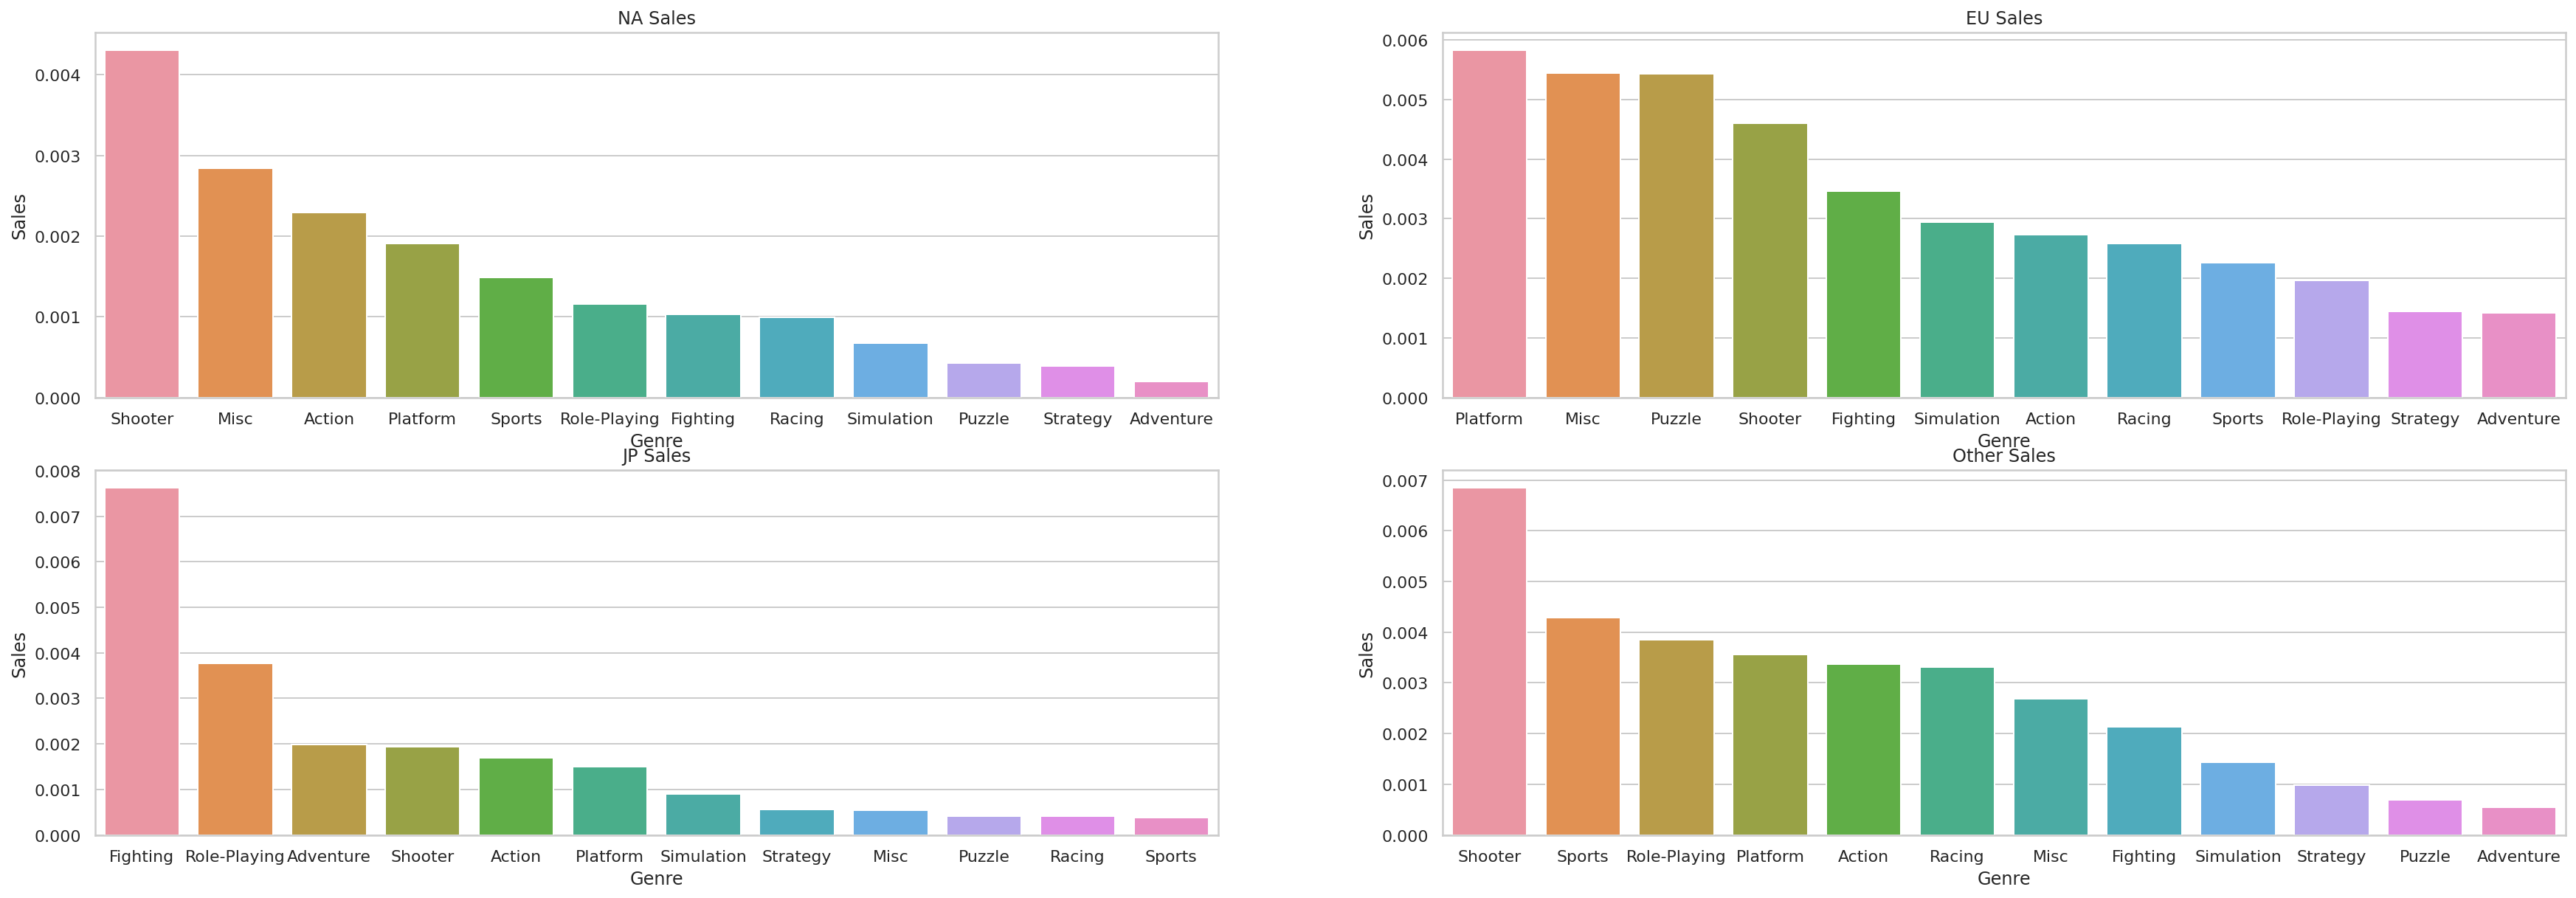

In [ ]:
# 사후 검정 시각화 및 결론
al = df.loc[df['Year'] >= 2010]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(30, 10)
sns.set_theme(style="whitegrid")

na = al.groupby('Genre')['NA_Sales'].describe().sort_values(by = 'mean', ascending = False)
na['Genre'] = na.index
eu = al.groupby('Genre')['EU_Sales'].describe().sort_values(by = 'mean', ascending = False)
eu['Genre'] = eu.index
jp = al.groupby('Genre')['JP_Sales'].describe().sort_values(by = 'mean', ascending = False)
jp['Genre'] = jp.index
other = al.groupby('Genre')['Other_Sales'].describe().sort_values(by = 'mean', ascending = False)
other['Genre'] = other.index

sns.barplot(x = 'Genre', y = 'mean', data = na, ax = ax1)
sns.barplot(x = 'Genre', y = 'mean', data = eu, ax = ax2)
sns.barplot(x = 'Genre', y = 'mean', data = jp, ax = ax3)
sns.barplot(x = 'Genre', y = 'mean', data = other, ax = ax4)

ax1.set_title("NA Sales")
ax1.set_ylabel('Sales')
ax2.set_title("EU Sales")
ax2.set_ylabel('Sales')
ax3.set_title("JP Sales")
ax3.set_ylabel('Sales')
ax4.set_title("Other Sales")
ax4.set_ylabel('Sales')
plt.show() 

---
## 연도별 게임의 트랜드
---
1. 연도별 플랫폼
2. 연도별 장르

In [ ]:
# 연도별 출시 게임 플랫폼
cro1 = pd.crosstab(df['Year'], df['Platform'])

chi1, pvalue1, _, _ = chi2_contingency(cro1, correction = True)
chi2, pvalue2, _, _ = chi2_contingency(cro1, correction = False)
print("플랫폼 P-value 값 : ", pvalue1)
print("플랫폼 P-value 값 : ", pvalue2)

# 연도별 출시 게임 장르
cro2 = pd.crosstab(df['Year'], df['Genre'])

chi1, pvalue1, _, _ = chi2_contingency(cro2, correction = True)
chi2, pvalue2, _, _ = chi2_contingency(cro2, correction = False)
print("장르 P-value 값 : ", pvalue1)
print("장르 P-value 값 : ", pvalue2)

플랫폼 P-value 값 :  0.0
플랫폼 P-value 값 :  0.0
장르 P-value 값 :  0.0
장르 P-value 값 :  0.0


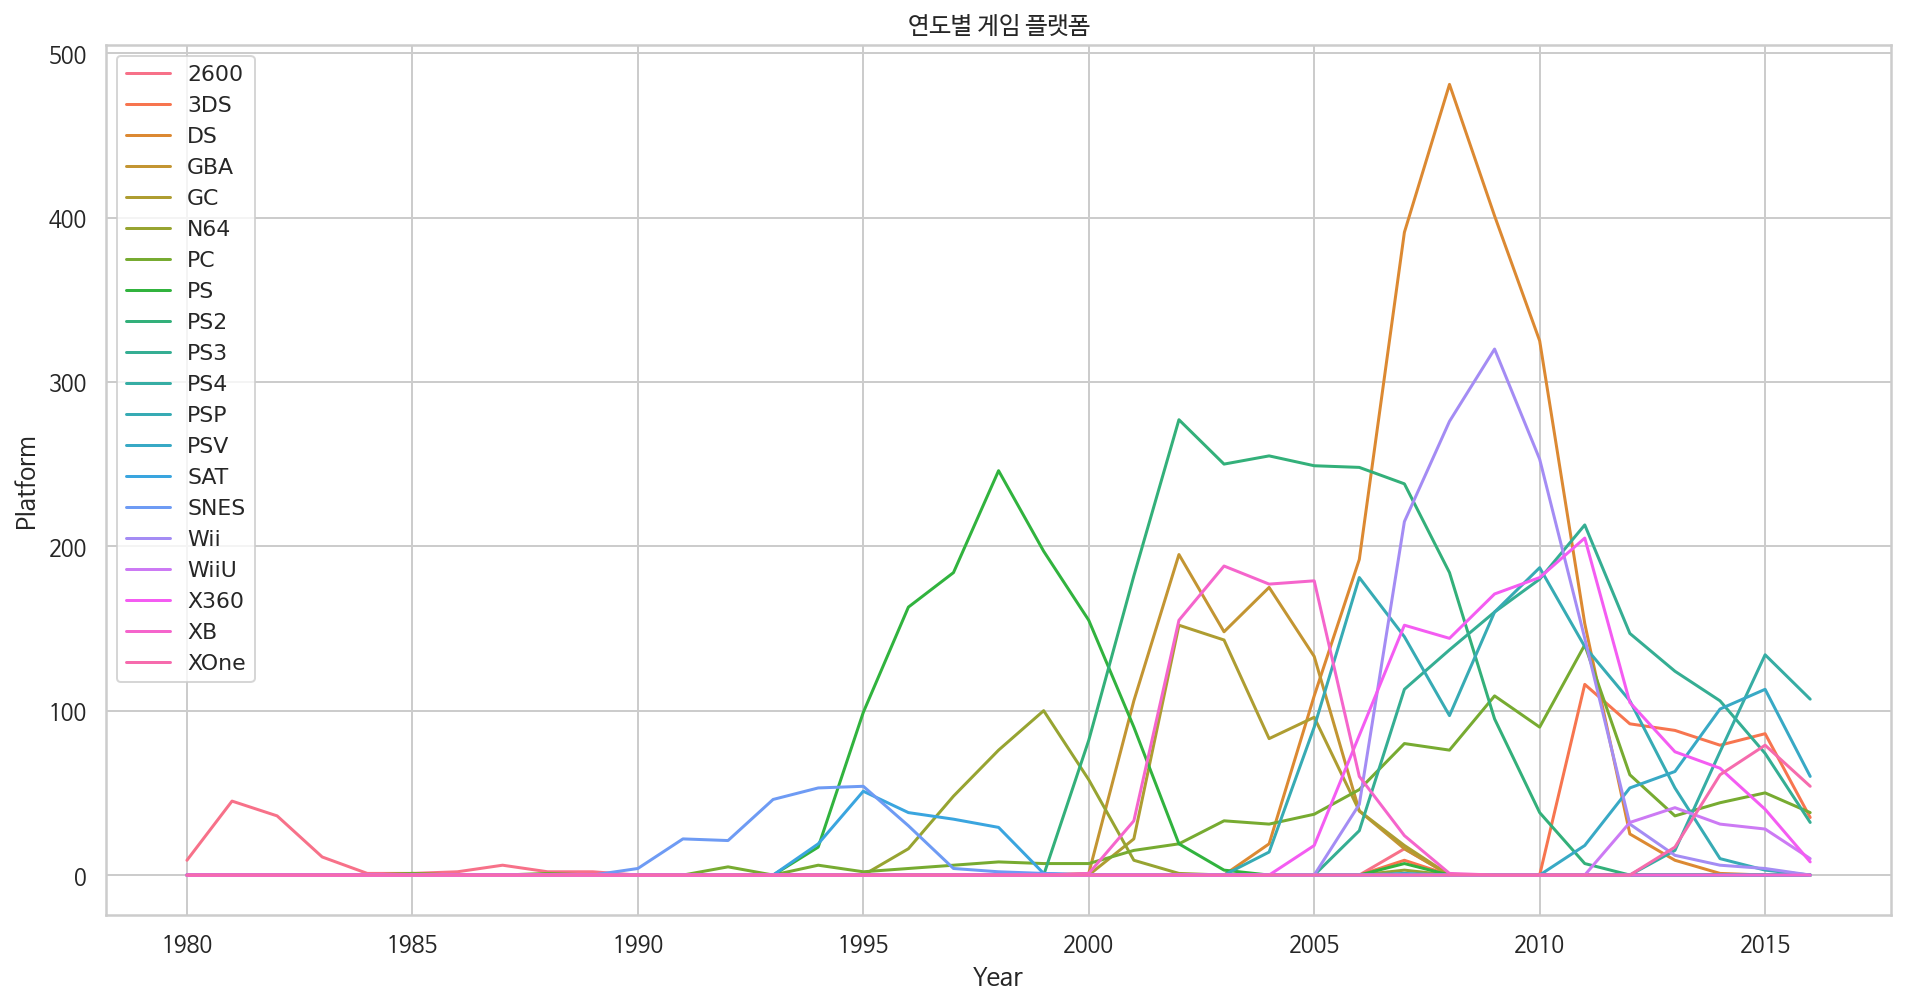

In [ ]:
cro1.columns.name = None
cro1.index.name = None

cro_col = cro1.columns.tolist()

for i in cro_col:
  if cro1[i].sum() < 100:
    cro1 = cro1.drop(i, axis = 1)

cro1 = cro1.loc[:2016,:]
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 8)
sns.set_theme(style="whitegrid")

sns.lineplot(data = cro1, dashes = False);
plt.rc('font', family='NanumBarunGothic') 
plt.title('연도별 게임 플랫폼')
plt.xlabel('Year')
plt.ylabel('Platform')
plt.show()

**결론**

2000년 : PS

2005년 : PS2

2010년 : DS, wii

2015년 : PS4, PSV

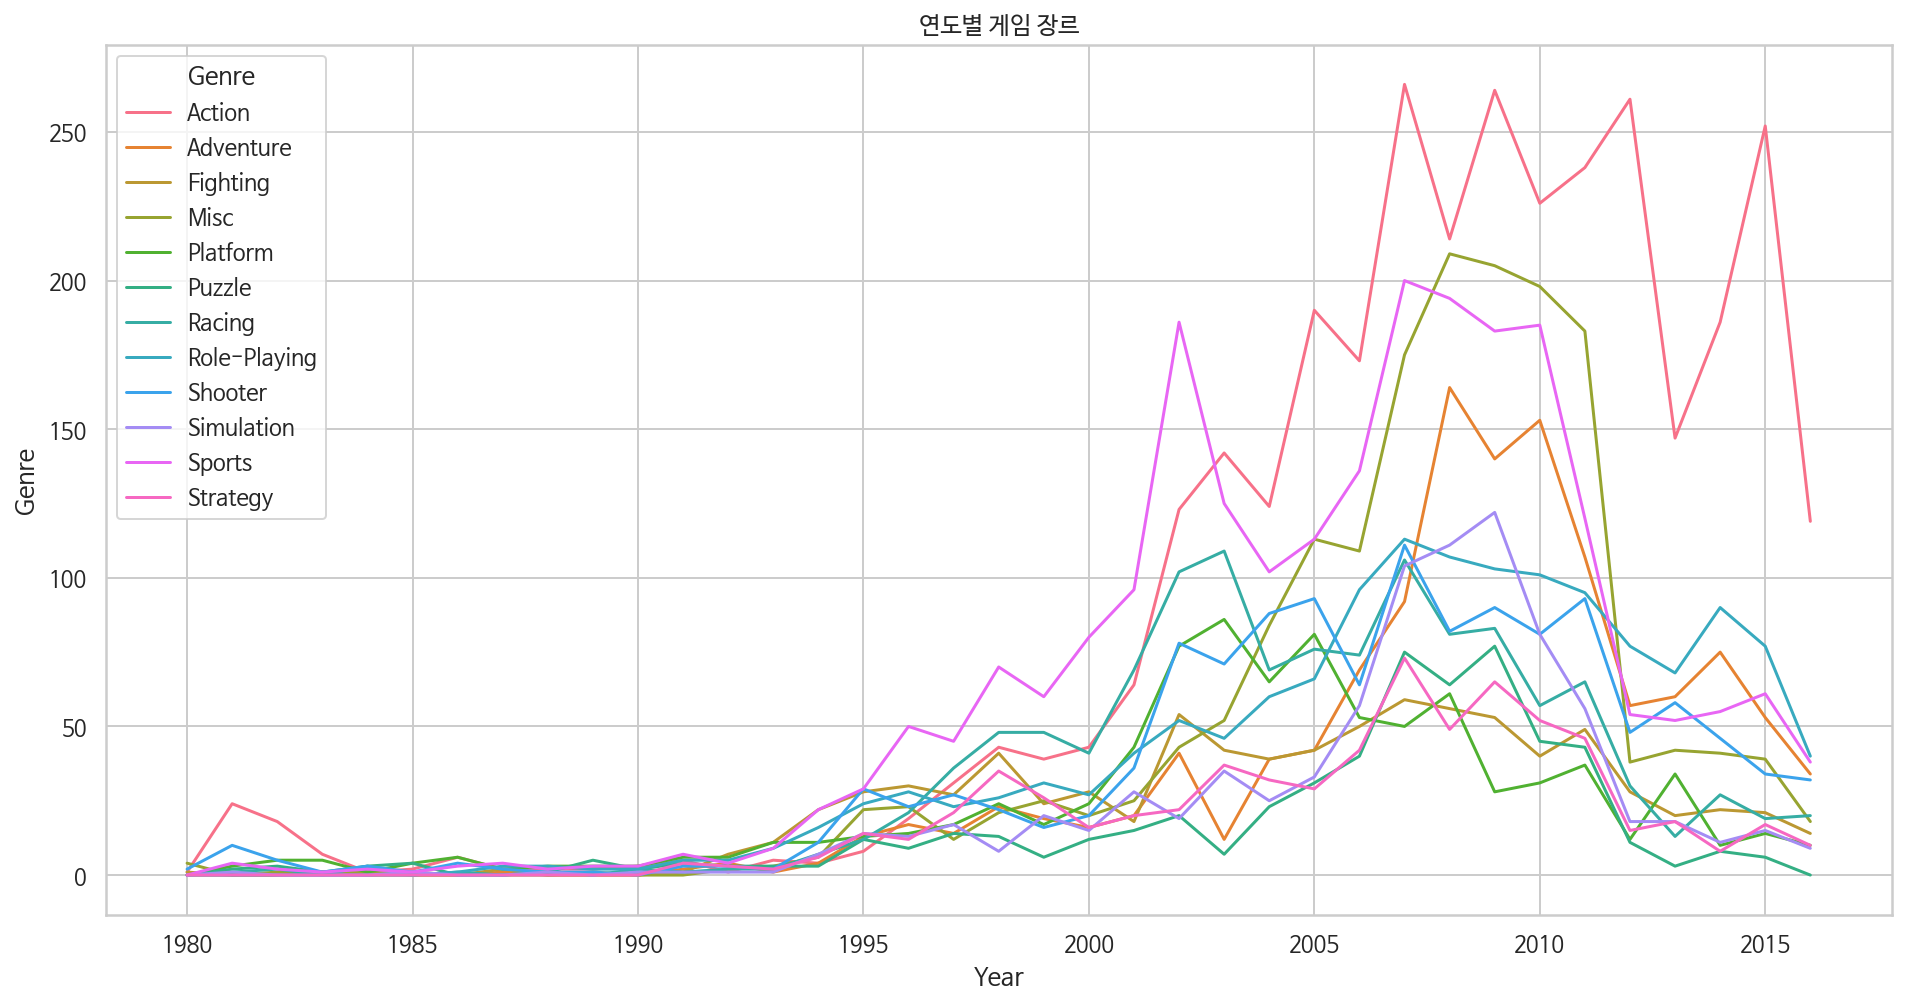

In [ ]:
cro2 = cro2.loc[:2016,:]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 8)
sns.lineplot(data = cro2, dashes = False);
plt.rc('font', family='NanumBarunGothic') 
plt.title('연도별 게임 장르')
plt.xlabel('Year')
plt.ylabel('Genre')
plt.show()

**결론**

2000년 : Sport

2005년 : Action

2010년 : Action

2015년 : Action

# 출고량이 높은 게임에 대한 분석 및 시각화 프로세스
1. 전체 출고량 높은 게임

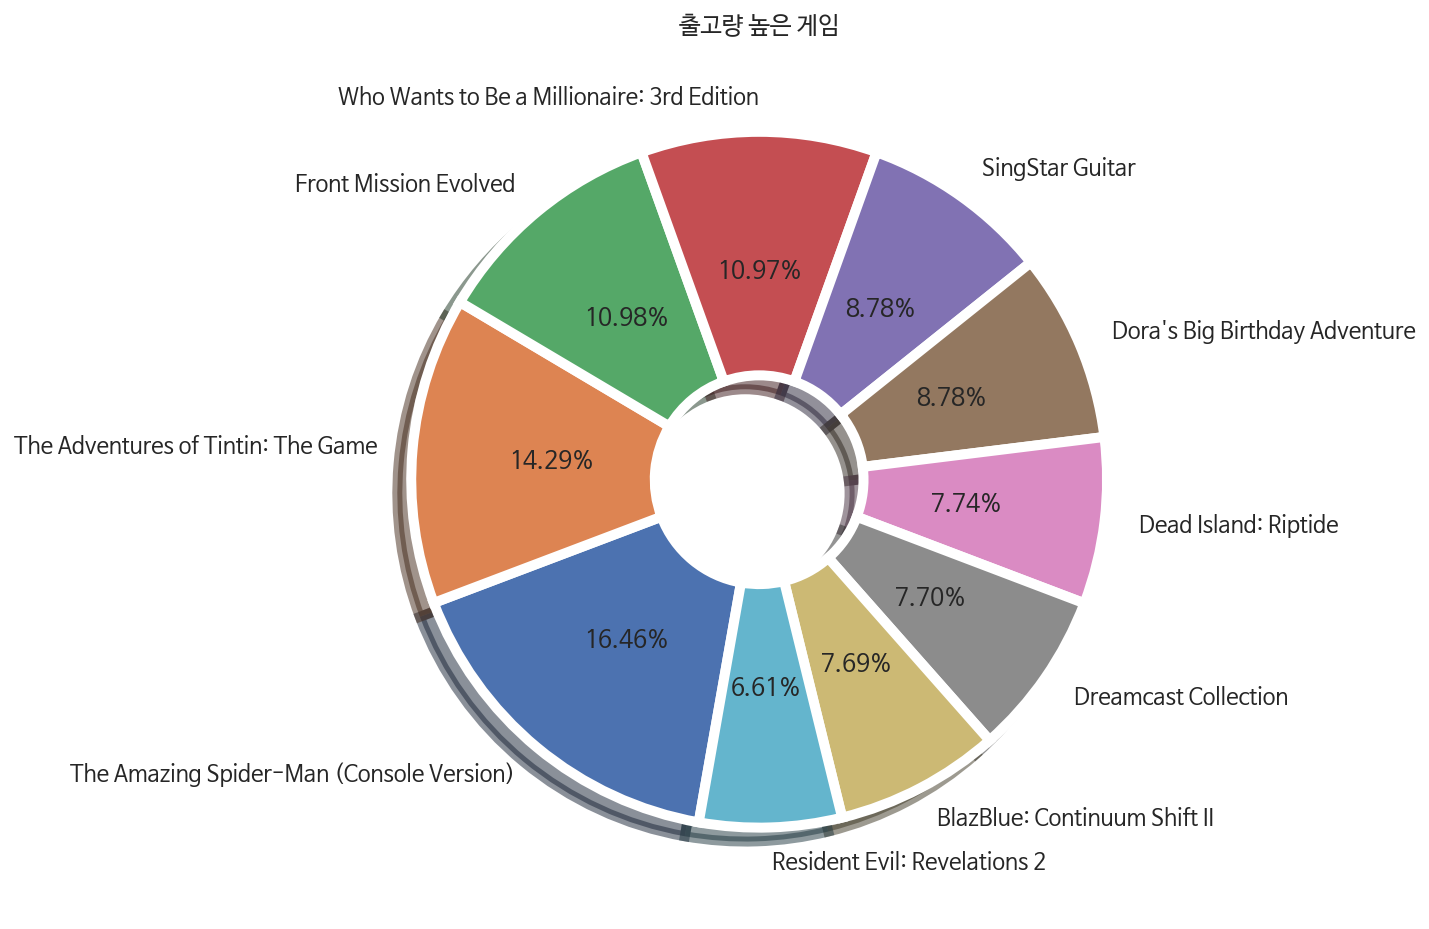

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,All_Sales
0,The Amazing Spider-Man (Console Version),DS,2012,Action,Activision,0.789474,0.000444,0.000000,0.0005,0.789488
1,The Adventures of Tintin: The Game,Wii,2011,Action,Ubisoft,0.684211,0.001889,0.000000,0.0020,0.685099
2,Front Mission Evolved,X360,2010,Shooter,Square Enix,0.526316,0.000778,0.000286,0.0010,0.526728
3,Who Wants to Be a Millionaire: 3rd Edition,Wii,2010,Misc,Ubisoft,0.526316,0.000000,0.000000,0.0005,0.526202
4,SingStar Guitar,PS3,2010,Misc,Sony Computer Entertainment,0.000000,0.888889,0.000000,0.0010,0.421025
5,Dora's Big Birthday Adventure,DS,2010,Misc,Take-Two Interactive,0.421053,0.000111,0.000000,0.0005,0.421025
6,Dead Island: Riptide,PS3,2013,Action,Deep Silver,0.001368,0.002222,1.000000,0.0045,0.371199
7,Dreamcast Collection,X360,2011,Misc,Sega,0.000842,0.777778,0.000000,0.0010,0.369252
8,BlazBlue: Continuum Shift II,PSP,2011,Fighting,PQube,0.000158,0.000222,1.000000,0.0005,0.368620
9,Resident Evil: Revelations 2,PS3,2015,Action,Capcom,0.315789,0.000889,0.002286,0.0015,0.317110


In [ ]:
# 전체 출고량 높은 게임
all = df.loc[df['Year'] >= 2010]
all = all.sort_values('All_Sales', ascending= False)[:10]

fig = plt.figure(figsize = (8, 8))
fig.set_facecolor('white')
ax = fig.add_subplot()
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
ax.pie(data = all, x = 'All_Sales', labels = 'Name', autopct=lambda p : '{:.2f}%'.format(p), startangle = 260, counterclock=False, shadow=True,  wedgeprops=wedgeprops)
plt.rc('font', family='NanumBarunGothic') 
plt.title('출고량 높은 게임')
plt.show()
all = all.reset_index(drop = True)
all

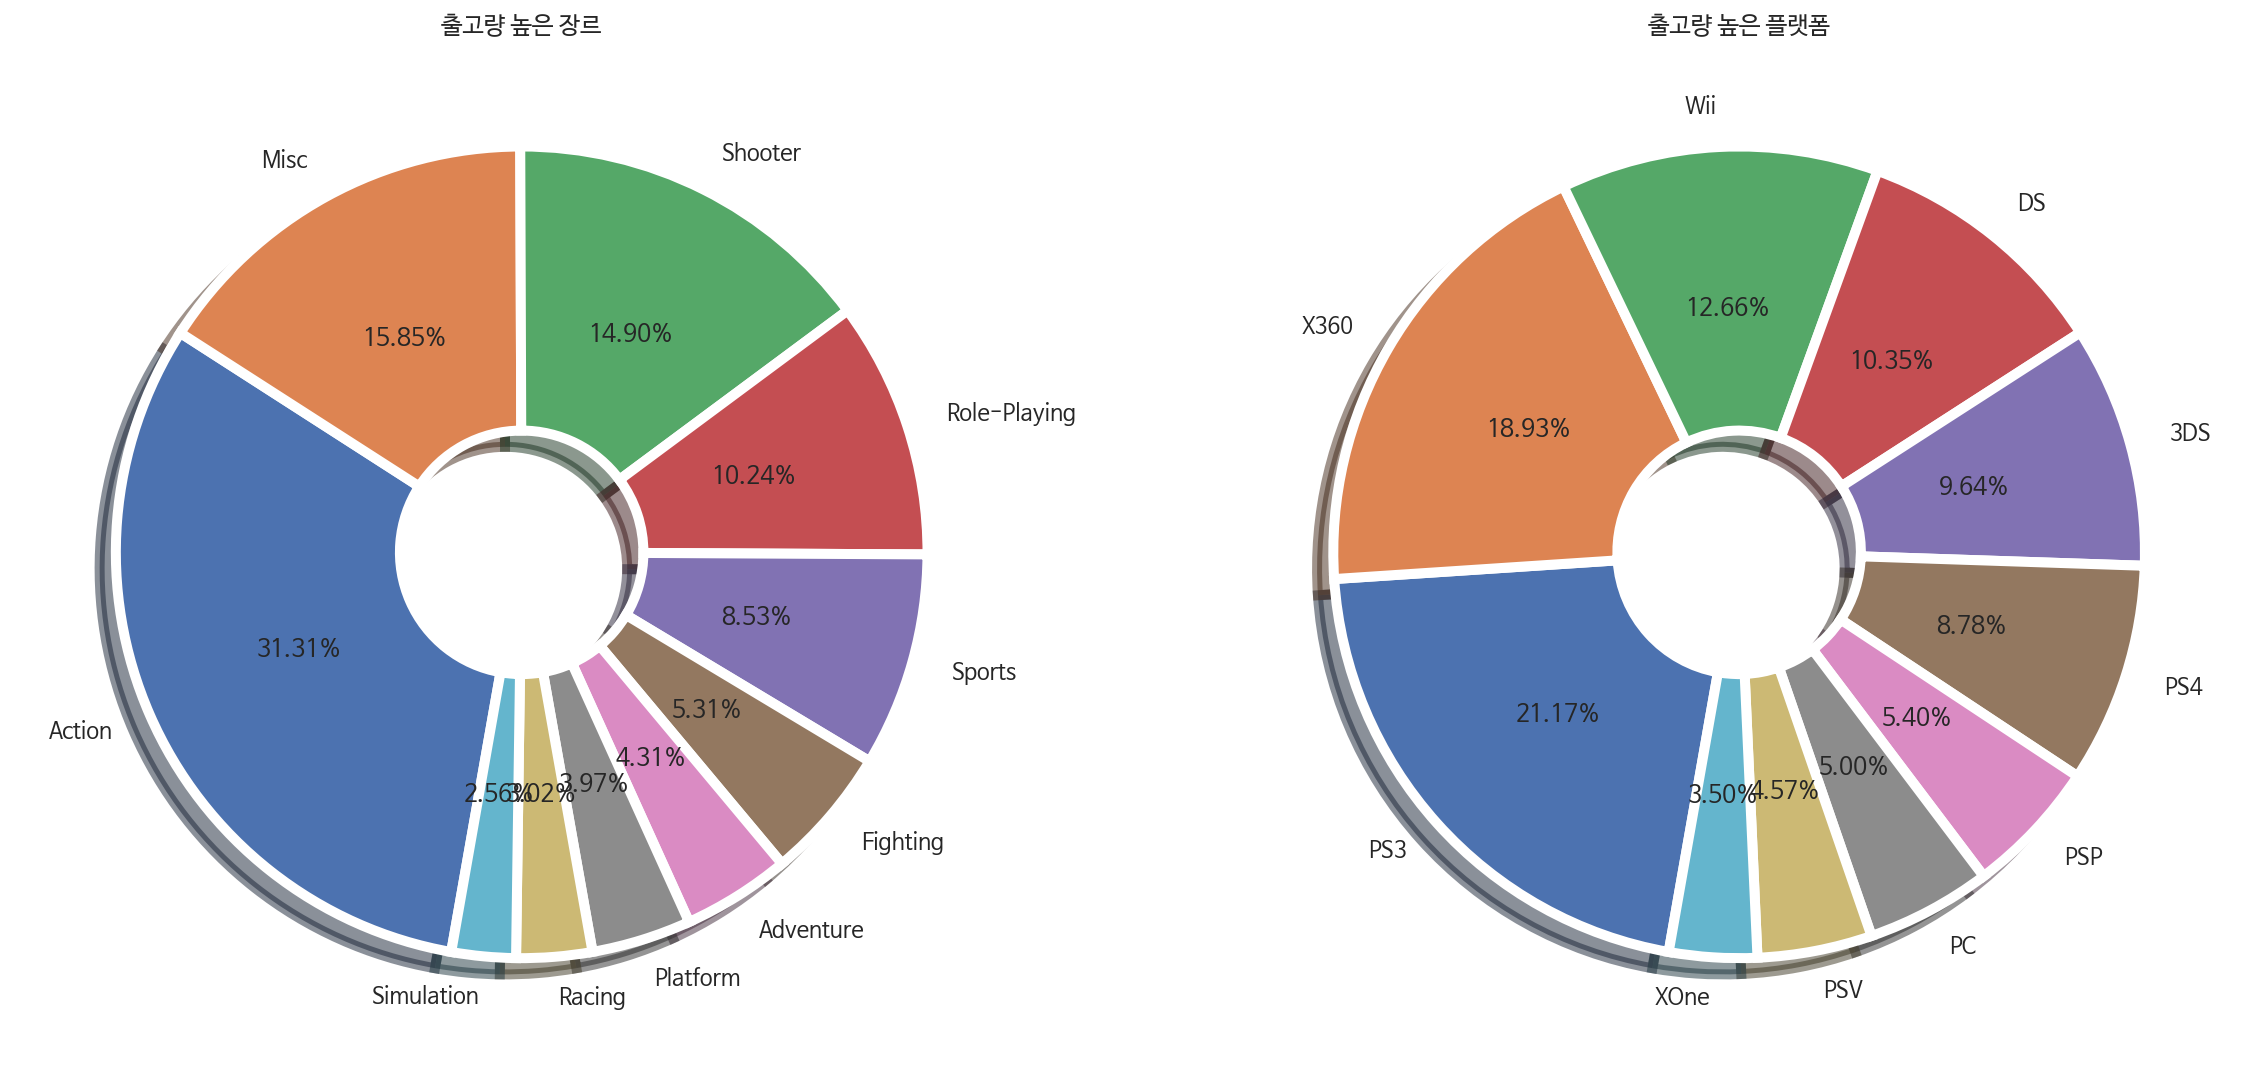

In [ ]:
gen = df.loc[df['Year'] >= 2010]
gen = gen.groupby('Genre').sum()
gen['Genre'] = gen.index
gen = gen.reset_index(drop = True)
gen_num = gen.sort_values(by = 'All_Sales', ascending = False)[:10]
gen_num['All_Sales'] = gen_num['All_Sales'] * 100

plat = df.loc[df['Year'] >= 2010]
plat = plat.groupby(['Platform']).sum()
plat['Platform'] = plat.index
plat = plat.reset_index(drop = True)
plat_num = plat.sort_values(by = 'All_Sales', ascending = False)[:10]
plat_num['All_Sales'] = plat_num['All_Sales'] * 100

fig = plt.figure(figsize = (20, 20))
fig.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

plt.rc('font', family='NanumBarunGothic') 
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
ax1.pie(data = gen_num, x = 'All_Sales', labels = 'Genre', autopct=lambda p : '{:.2f}%'.format(p), startangle = 260, counterclock=False, shadow=True,  wedgeprops=wedgeprops)
ax2.pie(data = plat_num, x = 'All_Sales', labels = 'Platform', autopct=lambda p : '{:.2f}%'.format(p), startangle = 260, counterclock=False, shadow=True,  wedgeprops=wedgeprops)
ax1.set_title('출고량 높은 장르')
ax2.set_title('출고량 높은 플랫폼')
plt.show()

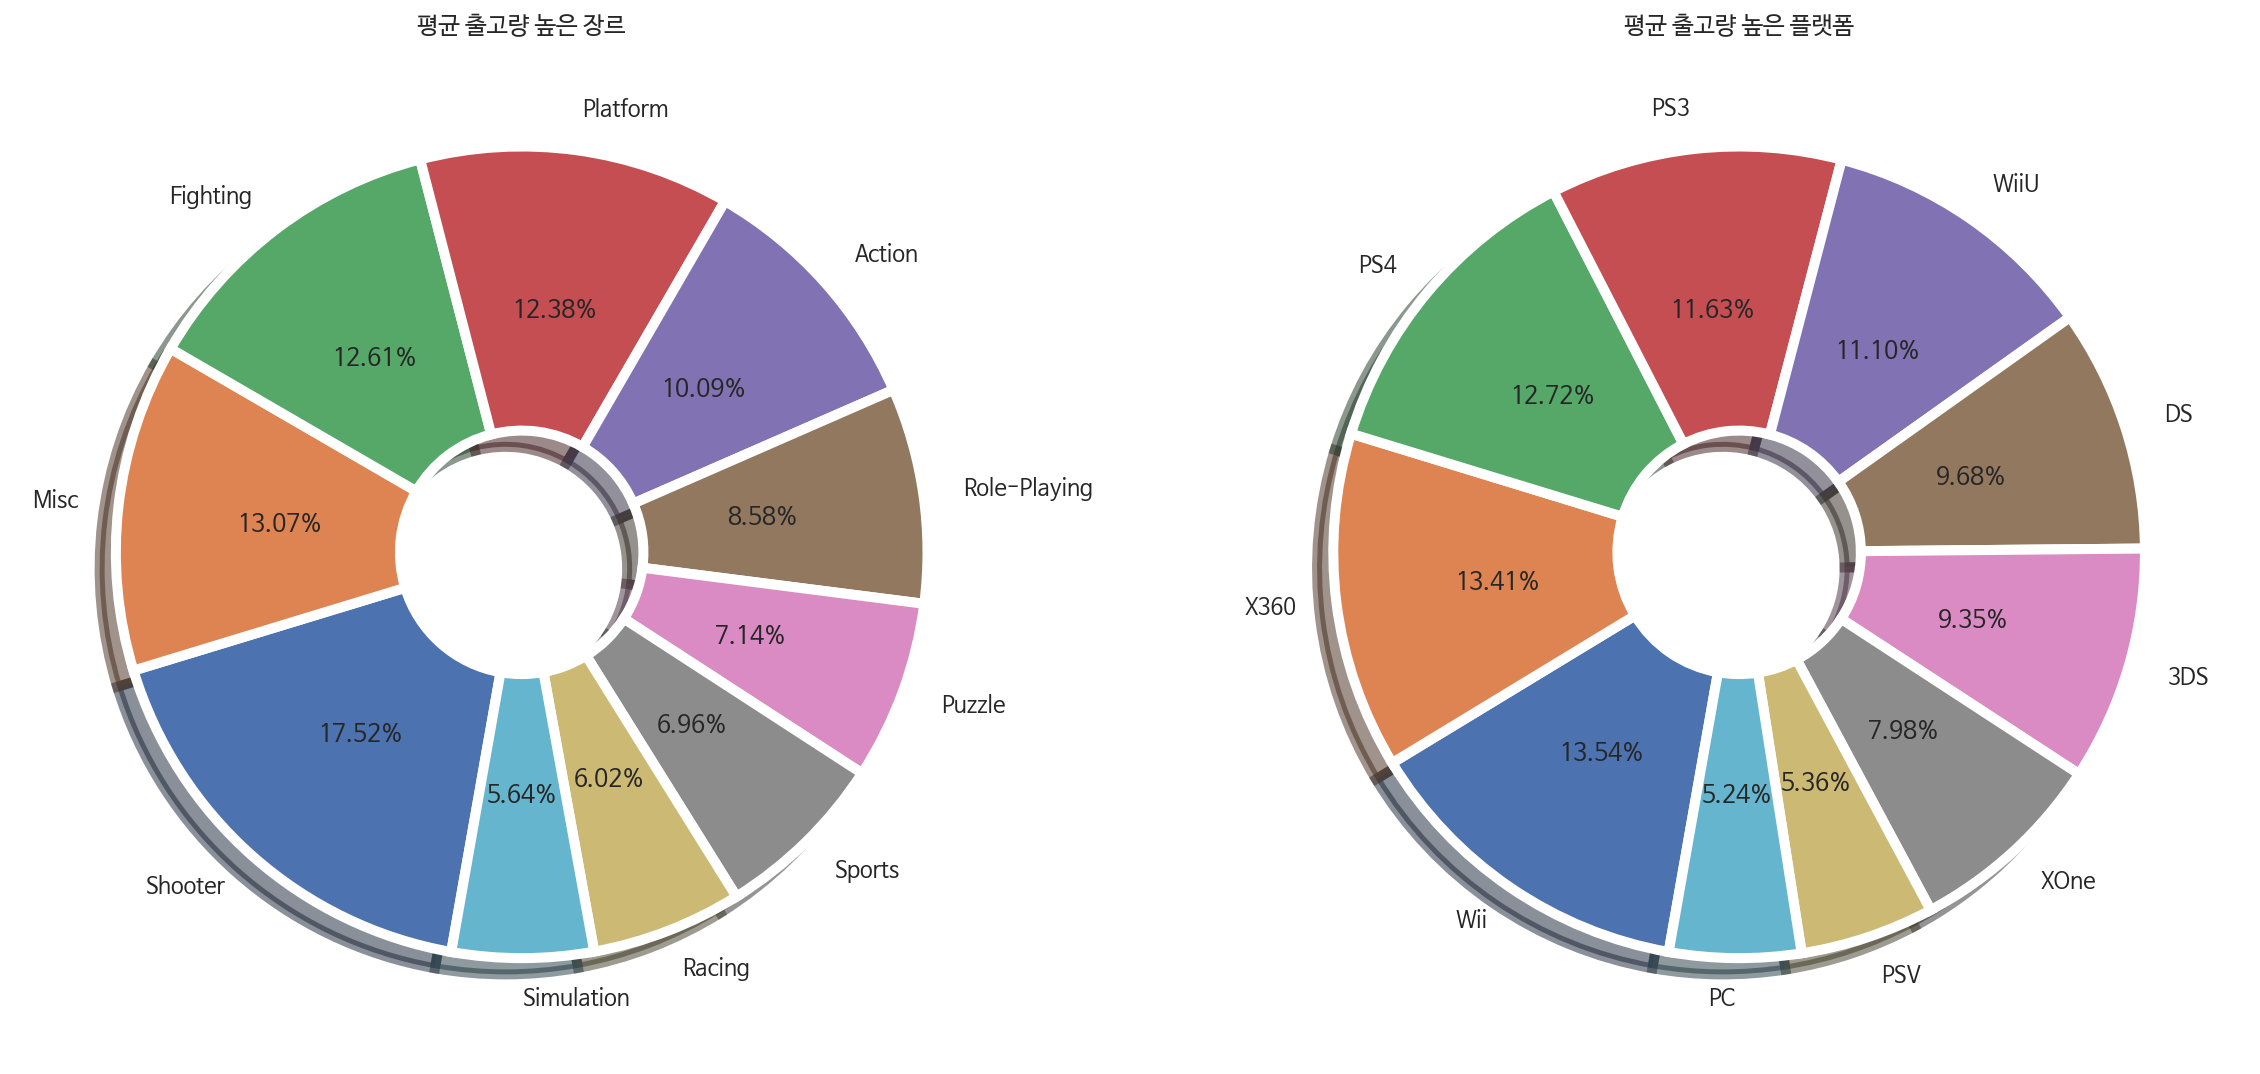

In [ ]:
gen = df.loc[df['Year'] >= 2010]
gen = gen.groupby('Genre').mean()
gen['Genre'] = gen.index
gen = gen.reset_index(drop = True)
gen_num = gen.sort_values(by = 'All_Sales', ascending = False)[:10]
gen_num['All_Sales'] = gen_num['All_Sales'] * 100

plat = df.loc[df['Year'] >= 2010]
plat = plat.groupby(['Platform']).mean()
plat['Platform'] = plat.index
plat = plat.reset_index(drop = True)
plat_num = plat.sort_values(by = 'All_Sales', ascending = False)[:10]
plat_num['All_Sales'] = plat_num['All_Sales'] * 100

fig = plt.figure(figsize = (20, 20))
fig.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

plt.rc('font', family='NanumBarunGothic') 
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
ax1.pie(data = gen_num, x = 'All_Sales', labels = 'Genre', autopct=lambda p : '{:.2f}%'.format(p), startangle = 260, counterclock=False, shadow=True,  wedgeprops=wedgeprops)
ax2.pie(data = plat_num, x = 'All_Sales', labels = 'Platform', autopct=lambda p : '{:.2f}%'.format(p), startangle = 260, counterclock=False, shadow=True,  wedgeprops=wedgeprops)
ax1.set_title('평균 출고량 높은 장르')
ax2.set_title('평균 출고량 높은 플랫폼')
plt.show()

# 결론
- 2010 이후 부터 Action 장르 게임이 많이 팔리고 있다.
- 2010 이후 부터 PS3, X360 게임이 많이 팔리고 있다.
- 2010 이후 부터 Action 장르 게임이 많이 출시되고 있다.
- 2010 이후 부터 PS3, X360 게임이 많이 출시되고 있다.

**2010 이후 평균적으로 출고량이 높은 Shooter 장르**

**2010 이후 평균적으로 출고량이 높은 Will, X360, PS4  플랫폼**

게임 개발을 추천 드립니다
